## Portfolio Optimalization - Asset Management
#### Arno Goedhuys /  r0636556 / 29 juni 2017

In [1507]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import norm
from scipy import interpolate
from cvxopt import matrix
from cvxopt.blas import dot
from cvxopt.solvers import qp, options
%matplotlib inline

#### Downloading the data
The data is downloaded from google finance. 
<p> The time interval runs from the first of january 2009 to the current date.

In [1508]:
assets = ['FOX','HAS','DISCA','MAR','NVDA','VOD','SBUX','GOOGL','ADBE','TRV','UNH','VZ','WMT','GS','DD','AXP','AAPL','MSFT','AMZN','YHOO','KO','CSCO','JPM','UTX','V','MCD','DIS', 'NKE','INTC','GE', 'PG', 'JNJ','HD','IBM','MMM']
pf_data = pd.DataFrame()

for asset in assets:
    pf_data[asset] = wb.DataReader(asset, data_source = 'google', start='2009-1-1')['Close']

In [1509]:
def add_stock(list_of_new_stocks):
    for asset in list_of_new_stocks:
        assets.append(asset)
        pf_data[asset] = wb.DataReader(asset, data_source = 'google', start='2009-1-1')['Close']
    return pf_data
pf_data = add_stock(['CHKP','CA','COST','BIDU'])

In [1510]:
pf_data = add_stock(['DLTR','EA','EBAY','EXPE','FAST','HOLX','GILD','TSCO','TXN','STX'])

In [1511]:
pf_data = add_stock(['ULTA','XRAY'])

In [1512]:
amount_of_assets = len(pf_data.columns)
print 'amount of assets: ', amount_of_assets
amount_of_trading_days = len(pf_data.index)
pf_data.head()

amount of assets:  51


,FOX,HAS,DISCA,MAR,NVDA,VOD,SBUX,GOOGL,ADBE,TRV,...,EBAY,EXPE,FAST,HOLX,GILD,TSCO,TXN,STX,ULTA,XRAY
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-02,10.17,29.60,14.65,20.06,8.71,20.39,4.92,160.82,23.02,45.20,...,14.66,8.26,18.26,6.50,26.09,9.18,16.04,5.08,8.30,29.11
2009-01-05,10.14,29.42,14.80,20.81,8.87,21.39,4.96,164.19,23.13,44.53,...,14.77,8.65,18.20,6.24,25.50,8.96,15.86,5.14,8.75,28.15
2009-01-06,10.50,29.28,14.99,21.63,9.17,21.88,5.11,167.20,24.22,43.17,...,15.18,8.97,18.02,6.24,24.82,8.70,16.45,5.78,8.99,27.40
2009-01-07,9.81,29.61,14.56,19.93,8.62,21.38,5.00,161.17,24.23,41.46,...,14.59,8.43,17.58,6.07,24.36,8.24,15.58,5.37,8.78,27.48
2009-01-08,9.71,28.90,15.08,20.45,8.40,21.33,5.07,162.76,24.29,42.23,...,14.67,8.94,16.80,5.72,24.44,8.25,15.28,5.60,6.97,27.81


#### Normalize data
Devide each value of each asset by its initial value and multipy by 100 so each asset starts with a value of 100. <p> Plot the evolution of each asset.

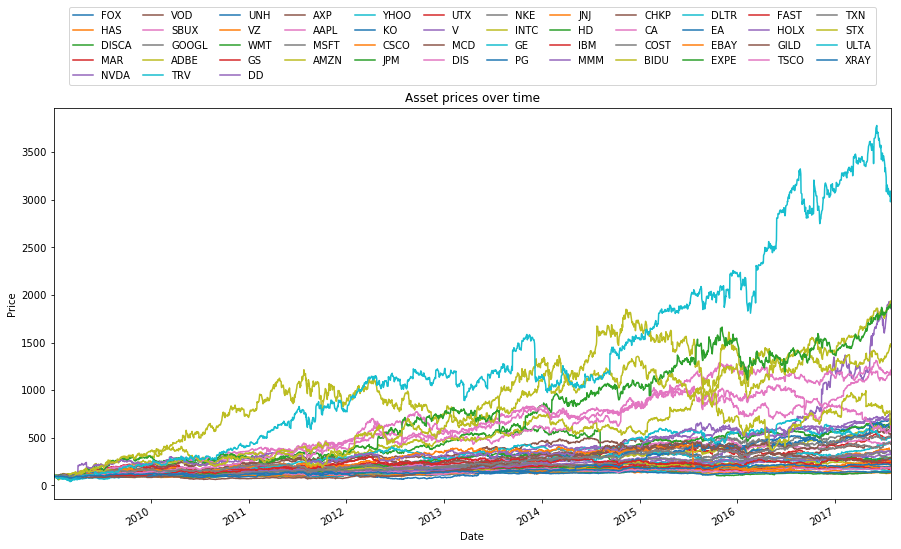

In [1513]:
normalized_data = pf_data / pf_data.iloc[0] * 100
(normalized_data).plot(figsize=(15,8))
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=12, mode="expand", borderaxespad=1.5)
plt.ylabel("Price")
plt.title("Asset prices over time")

#### Convert prices to returns and sample the returns
The returns will be modelled as simple returns: $$ r_i = \frac{P_{i+1}-P_i}{P_i} = \frac{P_{i+1}}{P_i} -1 $$

539


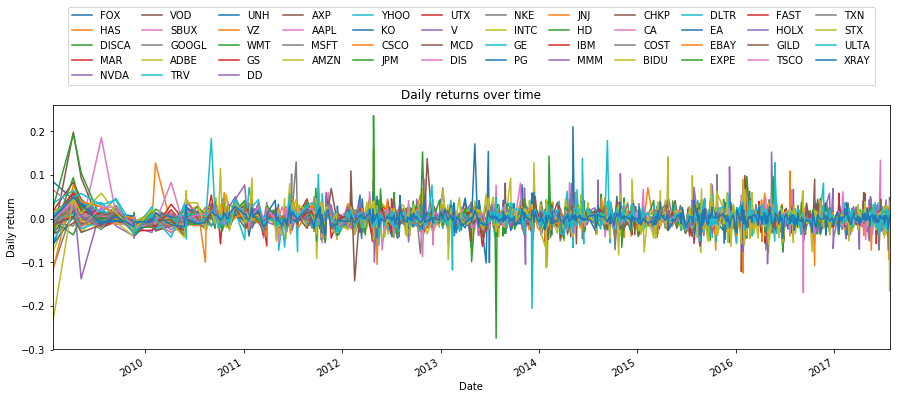

In [1560]:
probabilities = [x for x in range(len(normalized_data))]
daily_returns1 = normalized_data / normalized_data.shift(1) -1
daily_returns2 = daily_returns1.sample(frac=0.25,weights = probabilities)
amount_of_trading_days = len(daily_returns2.index)
daily_returns = daily_returns2.sort_index(ascending = True)
print len(daily_returns) #daily_returns.tail(), len(daily_returns), daily_returns1.tail(20)
(daily_returns).plot(figsize=(15,5))
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=12, mode="expand", borderaxespad=1.5)
plt.ylabel("Daily return")
plt.title("Daily returns over time")

### Risk free rate

The risk free rate is taken as the 10 year yield of the US treasury bond. Current yield : [Bloomberg Markets](https://www.bloomberg.com/markets/rates-bonds/government-bonds/us)

In [1561]:
risk_free_rate = 0.0232 # current 10 year yield on US treasury bond
#risk_free_return = [100*(1+0.0232/252.0)**x for x in range(amount_of_trading_days)]
risk_free_return = [0.0232/252.0 for x in range(len(daily_returns))]
risk_free_return = np.array(risk_free_return)
new_daily_returns = daily_returns.assign(risk_free=pd.Series(risk_free_return).values)
new_daily_returns.head()

,FOX,HAS,DISCA,MAR,NVDA,VOD,SBUX,GOOGL,ADBE,TRV,...,EXPE,FAST,HOLX,GILD,TSCO,TXN,STX,ULTA,XRAY,risk_free
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-22,-0.062796,-0.028200,0.015288,-0.016590,-0.018519,-0.036113,0.008850,0.011273,-0.078244,-0.050714,...,-0.035220,-0.001239,0.003425,-0.014170,-0.003593,-0.013736,-0.240000,0.006154,0.000377,0.000092
2009-04-09,0.060753,0.028725,0.044212,0.041237,0.055215,-0.010400,0.045296,0.029032,0.039716,0.016611,...,0.093855,0.058370,0.030814,0.005063,0.038462,0.026802,0.047244,0.048529,0.048375,0.000092
2009-05-08,0.030641,-0.015861,0.008960,0.042720,-0.137931,0.010377,-0.024286,0.027053,-0.008194,0.035752,...,0.022001,0.016093,0.003306,-0.031690,-0.019937,-0.015927,0.011688,0.057416,0.032628,0.000092
2009-07-22,0.007086,-0.007961,-0.001673,0.010553,0.025063,0.006871,0.185286,-0.000467,0.002559,0.015967,...,-0.002398,0.009368,-0.019244,-0.014415,0.026316,0.010403,0.058036,0.031306,-0.013436,0.000092
2009-09-14,0.007294,0.013394,0.000353,0.005285,-0.016544,-0.004741,0.010060,0.006305,0.015584,0.011981,...,0.008764,0.013757,0.022847,0.009111,0.026042,0.015170,0.014122,0.042766,0.004091,0.000092


#### Calculating the covariance matrix

In [1562]:
Covariance_matrix = daily_returns.cov() * 252
Rf_Covariance_matrix = new_daily_returns.cov() * 252
#print Covariance_matrix

#### Calculate the expected annual return and expected annual risk of a portfolio
A function to generate a given amount of random weights while making sure the sum of the weights equals 1.

In [1563]:
def gen_random_weights(amount):
    weights = np.random.random(amount)
    weights /= np.sum(weights)
    return weights
#print gen_random_weights(amount_of_assets)

The expected annual return is calculated as the amount of yearly trading days times the average daily return: $ E(r_{yearly}) = 252 * E(r_{daily}) $.

The portfolios expected annual return is given by: $ p = w^T * R_{yearly} $. Where w is the weight vector and $ R_{yearly} $ the expected annual return vector.

In [1564]:
def portfolio_return(D_returns, weights):
    annual_returns = D_returns.mean() * 252
    total_return = np.sum(annual_returns * weights)
    return total_return

portfolio_return(daily_returns, gen_random_weights(amount_of_assets))


0.2063297624177298

A function to calculate the expected volatility of a portfolio. The volatility is modelled as the standard deviation of portfolios returns. This be calculated as: $$ \sigma^2 = w^T*C*w $$
Where w is again the weights of the assets and C is the covariance matrix of the returns.

In [1565]:
def portfolio_volatility(C_matrix, weights):
    total_volatility = np.sqrt(np.dot(weights.T,np.dot(C_matrix, weights)))
    return total_volatility

portfolio_volatility(Covariance_matrix, gen_random_weights(amount_of_assets))

0.13918079345099557

In [1566]:
def convert_covariance_matrix(C_matrix):
    cov_matrix = C_matrix
    cov_matrix = cov_matrix.values
    cov_matrix = matrix(cov_matrix)
    return cov_matrix
#print convert_covariance_matrix(Covariance_matrix)

In [1567]:
def max_return(D_returns):
    annual_returns = D_returns.mean() * 252
    #print annual_returns
    return max(annual_returns)
max_return(daily_returns)

0.59383021719233808

#### Functions to return the parameters that need to be optimized with their weights as variables 
They are all calculated the same way as their numeric functions previously defined only the weights are variables instead of numeric values. Parameters that have to be maximized are taken negatively because the optimizations look for minimal values and the weights that give the maximal value are the same weights that given the minimal negative value.

The return in function of the weights.

In [1568]:
def returns(x):
    #amount_of_assets = len(normalized_data.columns)
    annual_returns = daily_returns.mean() * 252
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return -np.sum(annual_returns * variable)

The risk in function of the weights.

In [1569]:
def risk(x):
    #amount_of_assets = len(normalized_data.columns)
    cov_matrix = Covariance_matrix
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return np.sqrt(np.dot(variable.T,np.dot(cov_matrix, variable)))


The sharp ratio in function of the weights. The sharp ratio is the return devided by the risk.

In [1570]:
def sharp(x):
    #amount_of_assets = len(normalized_data.columns)
    #log_returns = np.log(normalized_data / normalized_data.shift(1))
    annual_returns = daily_returns.mean() * 252
    cov_matrix = Covariance_matrix
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return -(np.sum(annual_returns * variable)-risk_free_rate) / (np.sqrt(np.dot(variable.T,np.dot(cov_matrix, variable)))) 

#### Extra funtions usefull for the optimization


The contraint for the optimization, that the sum of the weights must be equal to one. 

In [1571]:
def constraint1(x):
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return np.sum(variable) - 1

A function to generate the valid interval for each weight.

In [1572]:
def gen_bounds(amount):
    bounds = []
    for i in range(amount):
        bounds.append((0,0.5))
    return bounds

### Convex optimization for minimal risk objective

The objective is to chose optimal weights to minimize the variance of the portfolios returns. The objective function has the form $ w^T*C*w $ and the constraints are that the sum of the weights equal one $ [1...1]*w = 1 $ and optionally a minimal return can be selected as $ w^T*r_{yearly} > r_{min} $ where $ r_{yearly} $ is the yearly return vector of each asset.

To use a convex optimizer the objective function has to be convex. A function like this is convex if the matrix C is positive definite, this is the case if the the function is positive for all possible weights vectors. Since the function represents the variance it will always be positive so a convex optimizer can be used. 

In [1573]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) >= 0)
print is_pos_def(convert_covariance_matrix(Covariance_matrix)), is_pos_def(convert_covariance_matrix(Rf_Covariance_matrix))

True True


In [1574]:
def convex_optimizer_weights(C_matrix, D_returns, minimal_return):
    options['show_progress'] = False
    n = len(D_returns.columns)
    #log_returns = np.log(assets / assets.shift(1))
    annual_returns = D_returns.mean() * 252
    cov_matrix = C_matrix
    cov_matrix = cov_matrix.values
    annual_returns = matrix(annual_returns)
    cov_matrix = matrix(cov_matrix)
    P = cov_matrix
    q = matrix(np.zeros((n, 1)))
    #G = matrix(np.concatenate((
    #             -np.transpose(np.array(annual_returns)), 
    #             -np.identity(n),np.identity(n)), 0))
    #h = matrix(np.concatenate((
    #             -np.ones((1,1))*minimal_return, 
    #              np.ones((n,1))*0.5,np.ones((n,1))*0.5), 0))
    G = matrix(np.concatenate((
                 -np.transpose(np.array(annual_returns)), 
                 -np.identity(n)), 0))
    h = matrix(np.concatenate((
                 -np.ones((1,1))*minimal_return, 
                  np.zeros((n,1))), 0))
    A = matrix(1.0, (1,n))
    b = matrix(1.0)
    weights = qp(P, q, G, h, A, b)
    return [weights['x'], np.sqrt(weights['primal objective'])]
print convex_optimizer_weights(Covariance_matrix, daily_returns, 0.1)


[<51x1 matrix, tc='d'>, 0.072531233944078885]


In [1575]:
def convert_weights(weights):
    optimum_weights = []
    for x in weights[0]:
            optimum_weights.append(x)
    return optimum_weights

In [1576]:
minimal_risk_weights = convert_weights(convex_optimizer_weights(Covariance_matrix, daily_returns, 0))
return_minimal_risk = portfolio_return(daily_returns, minimal_risk_weights)
print return_minimal_risk, #minimal_risk_weights

0.0852736509118


#### The optimizations
The optimization for the minimal risk portfolio. The extra constraints that each weight lies between 0 and 0.5 are set by the 
bounds attribute. The optimization used is the sequantial least squares programming. The site PyOpt explains it as:
> SLSQP optimizer is a sequential least squares programming algorithm which uses the Han–Powell quasi–Newton method with a BFGS update of the B–matrix and an L1–test function in the step–length algorithm. The optimizer uses a slightly modified version of Lawson and Hanson’s NNLS nonlinear least-squares solver. 
>
> [PyOpt](http://www.pyopt.org/reference/optimizers.slsqp.html)

The optimization for the maximal sharp portfolio. The same algorithm is used as with the minimal risk.

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2.57375816932
            Iterations: 13
            Function evaluations: 702
            Gradient evaluations: 13
0.410442111471 0.150457846462

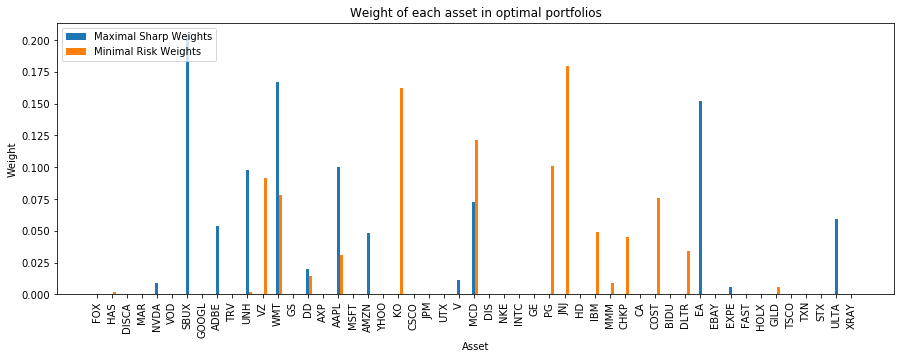

In [1577]:
maximal_sharp_weights = optimize.fmin_slsqp(sharp, amount_of_assets*[1./float(amount_of_assets),],eqcons=[constraint1],
                     bounds=gen_bounds(amount_of_assets))
return_maximal_sharp = portfolio_return(daily_returns, maximal_sharp_weights)
risk_maximal_sharp = portfolio_volatility(Covariance_matrix, np.array(maximal_sharp_weights))
print return_maximal_sharp, risk_maximal_sharp,# maximal_sharp_weights, 
plt.figure(figsize=(15,5))
ax = plt.subplot(111)
indeces = [x for x in range(len(assets))]
indeces2 = [x+0.2 for x in range(len(assets))]
ax.bar(indeces, maximal_sharp_weights,0.2)
ax.bar(indeces2, minimal_risk_weights,0.2)
ax.set_xticks(indeces)
ax.set_xticklabels(assets)
ax.set_ylabel("Weight")
ax.set_xlabel("Asset")
ax.set_title('Weight of each asset in optimal portfolios')
plt.setp(plt.xticks()[1], rotation=90)
plt.legend(['Maximal Sharp Weights', 'Minimal Risk Weights'], loc='upper left')
plt.show()

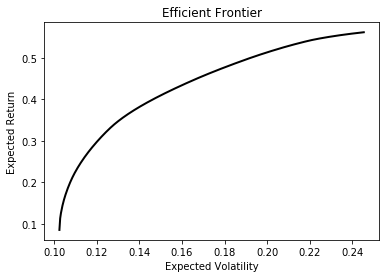

In [1578]:
def Efficient_Frontier(C_matrix, D_returns, amount_of_points, plot=True):
    opt_returns = []
    opt_risks = []
    optimum_weights = []
    minimal_risk_return = portfolio_return(D_returns, np.array(convert_weights(convex_optimizer_weights(C_matrix, D_returns, 0))))
    for i in range(amount_of_points):
        optimum_weights = []
        opt_weights = convex_optimizer_weights(C_matrix, D_returns, minimal_risk_return+i*(max_return(D_returns)-minimal_risk_return-0.03)/amount_of_points)
        #opt_weights = np.array(opt_weights)
        optimum_weights = convert_weights(opt_weights)
        opt_returns.append(portfolio_return(D_returns, optimum_weights))
        optimum_weights = np.array(optimum_weights)
        #print optimum_weights
        #opt_risks.append(np.sqrt(opt_weights[1]))
        opt_risks.append(portfolio_volatility(C_matrix, optimum_weights))
    f = interpolate.interp1d(opt_risks, opt_returns, kind='cubic') 
    xnew = np.arange(opt_risks[0],opt_risks[-2],(opt_risks[-2]-opt_risks[0])/amount_of_points)
    ynew = f(xnew)
    plt.title("Efficient Frontier")
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    if plot:
        plt.plot(xnew, ynew, 'k', linewidth=2.0)
    return f
Efficient_Frontier(Covariance_matrix, daily_returns, 400)

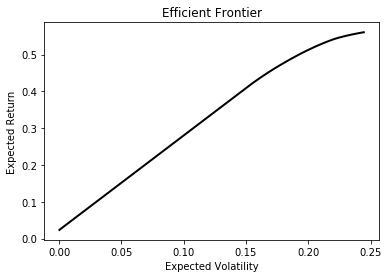

In [1579]:
Efficient_Frontier(Rf_Covariance_matrix, new_daily_returns, 400)

#### The results
The two optimized portfolios are plotted on a graph with the x axis the expected risk and the y axis the expected return. To illustrate that these are valid values 25000 other portfolio's with random weights are also plotted on the same graph. Out of the 25000 random portfolio's the one with the minimal risk is selected and returned to verify with the calculated weights, the same is done for the maximal sharp. 

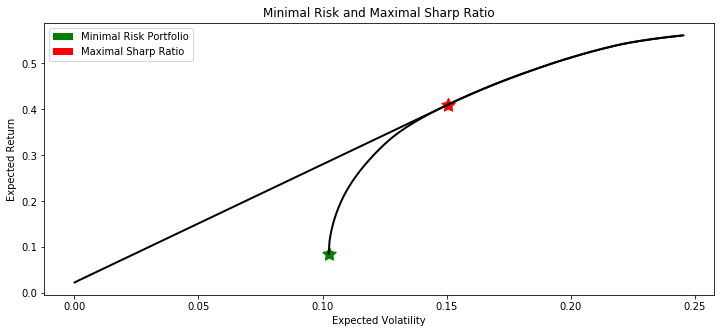

In [1580]:
def example_plot(D_returns):
    
    plt.figure(figsize=(12,5))
    Efficient_Frontier(Rf_Covariance_matrix, new_daily_returns, 400)
    Efficient_Frontier(Covariance_matrix, D_returns, 400)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    
    port_minrisk = portfolio_volatility(Covariance_matrix, np.array(minimal_risk_weights))
    port_return = portfolio_return(D_returns, minimal_risk_weights)
    plt.scatter(port_minrisk,port_return,marker=(5,1,0),color='g',s=200)
    
    #port_maxsharp = portfolio_volatility(assets, maximal_sharp_weights)
    #port_return = portfolio_return(assets, maximal_sharp_weights)
    plt.scatter(risk_maximal_sharp,return_maximal_sharp,marker=(5,1,0),color='r',s=200)
    
    plt.title("Minimal Risk and Maximal Sharp Ratio")
    #plt.title("Minimal Risk Portfolios")
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='g')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='r')

    plt.legend((p1, p2), ('Minimal Risk Portfolio', 'Maximal Sharp Ratio'), loc='best')
    #plt.legend((p1,), ('Minimal Risk Portfolio',), loc='best')
    plt.show()
    return #[min_risk_weights, max_sharp_weights, minimal_risk_weights, maximal_sharp_weights]
example_plot(daily_returns)

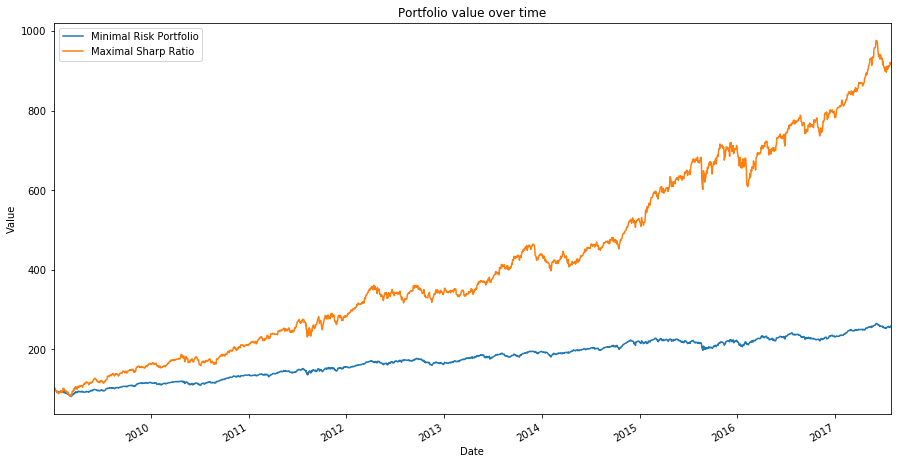

In [1582]:
portfolio_performance_min_risk = normalized_data.dot(minimal_risk_weights)
portfolio_performance_max_sharp = normalized_data.dot(maximal_sharp_weights)
(portfolio_performance_min_risk).plot(figsize=(15,8))
(portfolio_performance_max_sharp).plot(figsize=(15,8))
plt.legend(('Minimal Risk Portfolio', 'Maximal Sharp Ratio'), loc='best')
plt.ylabel("Value")
plt.title("Portfolio value over time")

### Different risk parameters


#### 1. VaR (Value at Risk)

Value at risk describes the worst losses at a given confidence level $ \alpha $ and over a given time period t. VaR can be calculated in two ways by taking the largest return in the $\alpha$ % interval of worst returns or by assuming the returns are normal and deriving the VaR from the mean and standard deviation.

First some functions that will be useful later are given.

In [272]:
def portfolio_daily_returns(assets, weights):
    returns = (assets.shift(1) - assets)/ assets
    portfolio_returns = returns.dot(weights)
    return portfolio_returns.drop(portfolio_returns.index[0])
portfolio_daily_returns(normalized_data, gen_random_weights(amount_of_assets)).head()

Date
2009-01-05   -0.010760
2009-01-06   -0.012958
2009-01-07    0.025111
2009-01-08   -0.023052
2009-01-09    0.012220
dtype: float64

First the VaR will be calculated by selecting the largest return in the lowest interval.

In [257]:
def HistoricVaR(assets, weights, alpha):
    return np.percentile(portfolio_daily_returns(assets,weights), alpha)
HistoricVaR(normalized_data, gen_random_weights(amount_of_assets), 0.05)

-0.067497245133756031

This method is more accurate than assuming a normal distribution because returns are not perfectly normal, but this method can not be used for optimization because every return is in function of the weights so it is unknown where the $ \alpha $ interval ends.

By assuming the returns follow a normal distribution, the VaR can be calculated as: $ VaR = \mu - F^{-1}(\alpha)* \sigma $. First a function to do this nurmerically then in function of the weights.

In [258]:
def normalVaR(assets, weights, alpha):
    var = portfolio_return(assets, weights) - norm.ppf(1-alpha) * portfolio_volatility(assets, weights)
    return var
normalVaR(normalized_data, gen_random_weights(amount_of_assets), 0.05)

-0.15483146492386771

In [259]:
def Var(x):
    log_returns = np.log(normalized_data / normalized_data.shift(1))
    annual_returns = log_returns.mean() * 252
    cov_matrix = log_returns.cov() * 252
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return -(np.sum(annual_returns * variable) - 1.65 * np.sqrt(np.dot(variable.T,np.dot(cov_matrix, variable))))


In [261]:
minimal_Var_weights = optimize.fmin_slsqp(Var, initial_guess(normalized_data,1000)[2].tolist(),eqcons=[constraint1],
                     bounds=gen_bounds(amount_of_assets))
print minimal_Var_weights, portfolio_return(normalized_data, minimal_Var_weights),portfolio_volatility(normalized_data, minimal_Var_weights)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0883821335378
            Iterations: 6
            Function evaluations: 37
            Gradient evaluations: 6
[ 0.5         0.11224243  0.32576283  0.06199474] 0.284601931788 0.226050948682


#### Conditional Value at risk
The Var expects the stocks returns to follow a perfect normal distribution. In reality when a stocks price falls hard it triggers other investors to sell, thus the large losses do not drop as quickly as the normal distribution supposes. Therefor it might be useful to take the expected value of the worst returns instead of the start of the 95% interval.

In [262]:
def HistoricCVaR(assets, weights, alpha):
    VaR = HistoricVaR(assets, weights, alpha)
    cVaR = np.nanmean(portfolio_daily_returns(assets, weights)[portfolio_daily_returns(assets, weights) < VaR])
    return cVaR
weight = gen_random_weights(amount_of_assets)
print HistoricCVaR(normalized_data, weight, 0.05) , HistoricVaR(normalized_data, weight, 0.05)

-0.0730809112731 -0.0722376857957


In [263]:
def daily_returns(x):
    data = []
    returns = (normalized_data.shift(1) - normalized_data) / normalized_data
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    for i in range(len(normalized_data.index)):
        data.append(-np.array(returns.iloc[i]).dot(variable))
    return data
#daily_returns(gen_random_weights(amount_of_assets))

In [264]:
len(normalized_data.index)

2153

In [265]:
weights = gen_random_weights(amount_of_assets)
print weights, np.array(normalized_data.iloc[2]).dot(weights)

[ 0.36579243  0.21782725  0.20113306  0.21524726] 102.753409759


In [270]:
def CVaR(x):
    data = []
    returns = (normalized_data.shift(1) - normalized_data) / normalized_data
    variable = []
    for i in range(amount_of_assets+1):
        variable.append(x[i])
    variable = np.array(variable)
    for i in range(len(normalized_data.index)):
        data.append(np.array(returns.iloc[i]).dot(variable[0:-1]))
    som = 0
    for i in range(len(normalized_data.index)):
        if i>0:
        #not np.isnan(max(data[i]-variable[0],0)): 
            som += max(data[i]-variable[-1],0)
    som = som/float(len(normalized_data.index))
    #print som
    return variable[-1] + 1/(1-0.95) * som
CVaR(gen_random_weights(amount_of_assets+1))
    

0.30992147979124512

In [267]:
def bounds(amount):
    bounds = []
    for i in range(amount):
        bounds.append((0,0.5))
    bounds.append((-0.5,0.5))
    return bounds

In [271]:
minimal_CVaR_weights = optimize.fmin_slsqp(CVaR, initial_guess(normalized_data,1000)[3].tolist(),eqcons=[constraint1],
                     bounds=bounds(amount_of_assets))
print minimal_CVaR_weights, portfolio_return(normalized_data, minimal_CVaR_weights[:-1]),portfolio_volatility(normalized_data, minimal_CVaR_weights[:-1]),HistoricCVaR(normalized_data,  minimal_CVaR_weights[:-1], 0.05)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0308142710345
            Iterations: 21
            Function evaluations: 157
            Gradient evaluations: 21
[ 0.3701338   0.35040658  0.09244963  0.18700999  0.02136954] 0.224527216235 0.205744321127 -0.0626853116943
